# Assignment 2 
## Farazulla Baig Mohammed
## W20082666

The purpose of this assignment is to use clustering and classification to predict various aspects of internet users based on data collected from a survey.

The survey has a large number of columns (features) so we need to choose a suitable subset both for clustering and for classification.

The rest of this notebook provides basic help with preparing the data for analysis.

## The layout of this notebook is as follows:
First we prepare the data for analysis. Then we select a subset of features for clustering. Then these are converted to dummy variables followed by Dimentionality reduction (PCA) for the clustering algorithms. Then a second subset of features are selected which follow the same treatment as before.

After clustering, a subset of attributes is selected, this time with a view to predicting `Major_Occupaion` and `Education_Attainment`. The selection of algorithms follow the scikit-learn algorithm cheat sheet. This exercise is repeated but with the reduced dimension data from PCA for finding any differences between the former without PCA and the latter with PCA.

## Background

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import sklearn.cluster as cluster
import w8support as w8s
import sklearn.cluster as cluster
from matplotlib import pyplot as plt


See https://www.openml.org/d/372 for description and https://www.openml.org/data/download/52407/internet_usage.arff for the data file itself. The data comprises mostly binary and some categorical (multi-valued) columns, with just 2 numeric columns, all relating to internet users circa 1997.

The first thing to do is to load the data.

In [ ]:
from scipy.io import arff
filePath = 'internet_usage.arff'
data, meta = arff.loadarff(filePath)
df = pd.DataFrame(data)
df.head()

As can be seen, the data is loaded into a dataframe but in a binary representation. We choose to convert the binary text into strings, as they are much easier to handle.

In [ ]:
for col in df.columns:
  df[col] = df[col].apply(lambda x: x.decode("utf-8"))
df.head()

The dataframe looks more standard now, but we notice that there is an anonymised user code 'who' which is a candidate for the dataframe's index. We check that each row has a unique 'who' value:

In [ ]:
numRows = df.shape[0]
numUniq = len(df['who'].unique().tolist())
print(numRows-numUniq)

It does, so we set 'who' as the index and it no longer appears in the list of columns, which we can check below.

In [ ]:
if 'who' in df.columns:
  df.set_index('who', inplace=True)

print(df.columns)

As can be seen, we have ensured that the 'who' column is no longer available as a feature. Also note that all columns are treated as 'object', effectively as strings.Then, the columns have been classified. The types of numeric and 'boolean' (0,1)-valued columns have also been changed. The latter are then binarised and ready for analysis.

In [ ]:
numericCols = ['Age', 'Opinions_on_Censorship']
boolCols = ['Community_Membership_Family', 'Community_Membership_Hobbies',
       'Community_Membership_None', 'Community_Membership_Other',
       'Community_Membership_Political', 'Community_Membership_Professional',
       'Community_Membership_Religious', 'Community_Membership_Support',
       'Disability_Cognitive', 'Disability_Hearing',
       'Disability_Motor', 'Disability_Not_Impaired', 'Disability_Not_Say',
       'Disability_Vision', 'How_You_Heard_About_Survey_Banner',
       'How_You_Heard_About_Survey_Friend',
       'How_You_Heard_About_Survey_Mailing_List',
       'How_You_Heard_About_Survey_Others',
       'How_You_Heard_About_Survey_Printed_Media',
       'How_You_Heard_About_Survey_Remebered',
       'How_You_Heard_About_Survey_Search_Engine',
       'How_You_Heard_About_Survey_Usenet_News',
       'How_You_Heard_About_Survey_WWW_Page', 'Not_Purchasing_Bad_experience',
       'Not_Purchasing_Bad_press', 'Not_Purchasing_Cant_find',
       'Not_Purchasing_Company_policy', 'Not_Purchasing_Easier_locally',
       'Not_Purchasing_Enough_info', 'Not_Purchasing_Judge_quality',
       'Not_Purchasing_Never_tried', 'Not_Purchasing_No_credit',
       'Not_Purchasing_Not_applicable', 'Not_Purchasing_Not_option',
       'Not_Purchasing_Other', 'Not_Purchasing_Prefer_people',
       'Not_Purchasing_Privacy', 'Not_Purchasing_Receipt',
       'Not_Purchasing_Security', 'Not_Purchasing_Too_complicated',
       'Not_Purchasing_Uncomfortable', 'Not_Purchasing_Unfamiliar_vendor',
           'Who_Pays_for_Access_Dont_Know',
       'Who_Pays_for_Access_Other', 'Who_Pays_for_Access_Parents',
       'Who_Pays_for_Access_School', 'Who_Pays_for_Access_Self',
       'Who_Pays_for_Access_Work']
strCols = ['Actual_Time', 'Community_Building', 'Country', 'Education_Attainment', 'Falsification_of_Information',
           'Gender', 'Household_Income', 'Major_Geographical_Location', 'Major_Occupation', 'Marital_Status',
           'Most_Import_Issue_Facing_the_Internet', 'Primary_Computing_Platform', 'Primary_Language',
           'Primary_Place_of_WWW_Access', 'Race', 'Registered_to_Vote', 'Sexual_Preference', 'Web_Ordering',
           'Web_Page_Creation', 'Willingness_to_Pay_Fees', 'Years_on_Internet' ]

for col in numericCols:
  df[col] = pd.to_numeric(df[col], errors='coerce')

for col in boolCols:
  df[col] = df[col].map({'0': 0, '1': 1})


According to the data description, the original internet_usage data had 2699 missing values in the 'Primary_Computing_Platform' column. In this version of the dataset, the missing values have already been replaced with '?', see below, so no further action is needed.

### Attribute column selection

Here, `Most_Import_Issue_Facing_the_Internet` ,`Gender` ,`Education_Attainment` and `Country` are chosen as the first subset of data for clustering. The goal is to find out the most concerning issue facing the internet taking Gender, Education and Country into consideration. To help in making the decision of choosing certain attributes, RapidMiner was used. This helped in deselecting those columns with poor quality which is suggested in RapidMiner with the red colored status bubble. Here, only four features are selected as it is easier to interpret these rather than having around 10 features and understanding any useful information provided by the clusters.

In [ ]:
col = 'Most_Import_Issue_Facing_the_Internet'
df[col].value_counts()

In [ ]:
col = 'Gender'
df[col].value_counts()

In [ ]:
col = 'Education_Attainment'
df[col].value_counts()

In [ ]:
col = 'Country'
df[col].value_counts()

one-hot encoding maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values.

In [ ]:
def dfSub(originalStrCols):
    from sklearn.preprocessing import OneHotEncoder

    ohe = dict()
    
    # Create an empty dataframe
    dfSub = pd.DataFrame()

    for col in originalStrCols:
      ohe[col] = OneHotEncoder(sparse=False)
      X = ohe[col].fit_transform(df[col].values.reshape(-1,1))
      # See https://stackoverflow.com/a/4843172
      dfOneHot = pd.DataFrame(X, columns = [col+'-'+str(int(i)) for i in range(X.shape[1])])
      dfSub = pd.concat([dfSub, dfOneHot], axis=1)

    # Assign the index so that it matches that of the original df
    dfSub.set_axis(df.index, axis='index', inplace=True)

    # Add in the sampledBoolcols
    dfSub.shape
    return dfSub

Calling the one-hot endcoder function by selecting first feature subset

In [ ]:
dfSub1=dfSub(['Most_Import_Issue_Facing_the_Internet','Gender','Education_Attainment','Country'])

### Standardization of the Data
PCA is effected by scale so we need to scale the features in the data before applying PCA. Using StandardScaler helps to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms


In [ ]:
from sklearn.preprocessing import StandardScaler
dfSub1 = StandardScaler().fit_transform(dfSub1)

### Dimensionality reduction(PCA)
In this section, the code projects the scaled data into 2 dimensions. It should be noted that after dimensionality reduction, there usually isn’t a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [ ]:
def pcaFunction(dfSub):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    dfSubT = pca.fit_transform(dfSub)
    return dfSubT

In [ ]:
dfSub1=pcaFunction(dfSub1)

#### Using the elbow method to find the optimum number of clusters


In [ ]:
def elbowCluster(dfSub1):
    from sklearn.cluster import KMeans
    wcss = []
    for i in range(1,11):
        km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
        km.fit(dfSub1)
        wcss.append(km.inertia_)
    plt.plot(range(1,11),wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('wcss')
    plt.show()

In [ ]:
elbowCluster(dfSub1)

This method suggests that the number of optimal clusters are 3 which is at the graph's "elbow".
But, this test is not sufficient on it’s own to cluster data and draw conclusions as elbow method is subjective. This clustering can be enhanced using further engineering to choose the data metrics in a meaningful way to enhance the analysis.

### 1. Hierarchical Algorithm

In [ ]:
def hierarchicalAlgorithm(dfSub1,n_clusters):
    from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

    sns.set_context('poster')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.25, 's' : 15, 'linewidths':0}
    paletteName = 'deep'
    fontSize = 10
    fc = '#cccccc'

    algName = "AgglomerativeClustering"
    for link in ['complete', 'average', 'ward', 'single']:
        plt.figure()
        start_time = time.time()
        Z = linkage(dfSub1, method=link)
        R = dendrogram(Z, p=30, truncate_mode='lastp')
        end_time = time.time()
        elapsed_time = end_time-start_time
        print(elapsed_time)

        title = '{} linkage {}'.format(algName,link)
        outFile = 'pic/{}_{}_generated.pdf'.format(algName,link)
        plt.title(title, fontsize=10)
        plt.savefig(outFile)

        res = cut_tree(Z, n_clusters)
        labels = np.ravel(res)
        fig=plt.figure() # Start new plot
        nClusters = len(set(labels))
        title = '{} Clusters found by {} linkage={}'.format(str(nClusters),'dendrogram',link)
        ax = sns.scatterplot(x=dfSub1[:,0], y=dfSub1[:,1], hue=labels, style=labels)
    #     plt = w8s.plot_2dClusters(dfSub, labels, title, paletteName, fontSize, plot_kwds,)
        fig.suptitle(title, fontsize=12)
        outFile = 'pic/{}{}_{}_generated.pdf'.format('dendrogram',str(nClusters),link)
        plt.savefig(outFile)

In [ ]:
hierarchicalAlgorithm(dfSub1,3)

The dendrogram plots are very useful for determining the structure of features in the data.

The Ward linkage function appears to be the best fit to this data, as it provides a nice split and arguably the
best clustering of the 4 linkage functions. Based on this we confirm that the number of clusters are 3.

### 2. K-Means Algorithm

In [ ]:
def kMeansAlgorithm(dfSub1,nClusters):
    from scipy.spatial.distance import cdist
    import matplotlib.pyplot as plt

    sns.set_context('poster')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.25, 's' : 15, 'linewidths':0}
    paletteName = 'deep'
    fontSize = 10
    fc = '#cccccc'
    
    outFile = 'pic/kmeans6_generated.pdf'
    clusterParams = {'n_clusters':nClusters, 'random_state':0}
    algName = "KMeans"

    start_time = time.time()
    kmeans = cluster.KMeans(**clusterParams)
    labels = kmeans.fit_predict(dfSub1)
    end_time = time.time()
    elapsed_time = end_time-start_time
    print(elapsed_time)

    title = '{} Clusters found by {}'.format(str(nClusters),algName)
    ax = sns.scatterplot(x=dfSub1[:,0], y=dfSub1[:,1], hue=labels, style=labels)
    ax.set_title(title)
    outFile = 'pic/{}{}_generated.pdf'.format(algName,str(nClusters))
    plt.savefig(outFile)

    title = '{} Clusters (with regions) found by {}'.format(str(nClusters),algName)
    centres = kmeans.cluster_centers_
    radii = [cdist(dfSub1[labels == i], [center]).max()
             for i, center in enumerate(centres)]
    
    plt = w8s.overlayDisks(plt, centres, radii, fc, plot_kwds)
    outFile = 'pic/{}{}withCentres_generated.pdf'.format(algName,str(nClusters))
    plt.savefig(outFile)

In [ ]:
kMeansAlgorithm(dfSub1,3)

The features here are not circular, so k-means needs to create larger cluster "regions" that overlap. It is clearly not the best choice for this data.The boundaries of the disks are not distinct from each other and hence overlap.

### 3. DBSCAN Algorithm

In [ ]:
def dbscanAlgorithm(dfSub1):    
    import matplotlib.pyplot as plt
    
    sns.set_context('poster')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.25, 's' : 15, 'linewidths':0}
    paletteName = 'deep'
    fontSize = 10
    fc = '#cccccc'
    
    algName = "DBSCAN"
    for eps in [0.05,0.08, 0.1]:
        clusterParams = {'eps':eps}
        start_time = time.time()
        dbscan = cluster.DBSCAN(**clusterParams)
        labels = dbscan.fit_predict(dfSub1)
        # Subsequently, this will be invoked using a function call of the form
        # dbscan, labels = w8s.fitClusterLabels(data, cluster.DBSCAN, (), clusterParams)
        end_time = time.time()
        elapsed_time = end_time-start_time
        print(elapsed_time)

        plt.clf() # Start new plot
        nClusters = len(set(labels))
        title = '{} Clusters found by {} with eps={}'.format(str(nClusters),algName,str(eps).replace('.','p'))
        ax = sns.scatterplot(x=dfSub1[:,0], y=dfSub1[:,1], hue=labels)
        ax.set_title(title)
        outFile = 'pic/{}{}_{}_generated.pdf'.format(algName,str(nClusters),str(eps))
        plt.savefig(outFile)

In [ ]:
dbscanAlgorithm(dfSub1)

As can be seen, `DBSCAN` starts to model "noise" when `eps` is too large.It tends to overfit. `HDBSCAN` extends `DBSCAN` by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters making configuration much easier. More importantly `HDBSCAN` is noise aware – it has a notion of data samples that are not assigned to any cluster

### 4. HDBSCAN Algorithm

In [ ]:
def hdbscanAlgorithm(dfSub1):
    import hdbscan
    import matplotlib.pyplot as plt
    
    sns.set_context('poster')
    sns.set_color_codes()
    plot_kwds = {'alpha' : 0.25, 's' : 15, 'linewidths':0}
    paletteName = 'deep'
    fontSize = 10
    fc = '#cccccc'
    
    algName = "HDBSCAN"
    for minClusterSize in [90,95,100]:
        clusterParams = {'min_cluster_size':minClusterSize}
        start_time = time.time()
        hdbscanModel = hdbscan.HDBSCAN(**clusterParams)
        labels = hdbscanModel.fit_predict(dfSub1)
        # Subsequently, this will be invoked using a function call of the form
        # hdbscan, labels = w8s.fitClusterLabels(data, hdbscan.HDBSCAN, (), clusterParams)
        end_time = time.time()
        elapsed_time = end_time-start_time
        print(elapsed_time)

        plt.clf() # Start new plot
        nClusters = len(set(labels))
        title = '{} Clusters found by {} minClusterSize={}'.format(str(nClusters),algName,str(minClusterSize))
        ax = sns.scatterplot(x=dfSub1[:,0], y=dfSub1[:,1], hue=labels)
        ax.set_title(title)
        outFile = 'pic/{}{}_{}_generated.pdf'.format(algName,str(nClusters),str(minClusterSize))
        plt.savefig(outFile)


In [ ]:
hdbscanAlgorithm(dfSub1)

Compared to Agglomerative Clustering, this does not perform significantly well in identifying clusters even after increasing cluster size greatly.

### 5. Gaussian Mixture Model

In [ ]:
 def gmmAlgorithm(dfSub1,n_components):
    import matplotlib.pyplot as plt
    import sklearn.mixture as mixture
    
    algName = "GaussianMixture"
    for covType in ['spherical', 'full']:
        clusterParams = {'n_components':n_components, 'covariance_type':covType, 'max_iter':250, 'random_state':0}
        start_time = time.time()
        gaussianMixture = mixture.GaussianMixture(**clusterParams)
        labels = gaussianMixture.fit(dfSub1).predict(dfSub1)
        end_time = time.time()
        elapsed_time = end_time-start_time
        print(elapsed_time)

        plt.clf() # Start new plot
        nClusters = len(set(labels))
        title = '{} Clusters found by {}'.format(str(nClusters),algName)
        ax = sns.scatterplot(x=dfSub1[:,0], y=dfSub1[:,1], hue=labels, style=labels)
        ax.set_title(title)
        outFile = 'pic/{}{}_{}_generated.pdf'.format(algName,str(nClusters),covType)
        plt.savefig(outFile)

        title = '{} Clusters (with regions) found by {}'.format(str(nClusters),algName)
        weights = gaussianMixture.weights_
        means = gaussianMixture.means_
        covariances = gaussianMixture.covariances_
        plt = w8s.overlayEllipses(plt, weights, means, covariances)
        outFile = 'pic/{}{}_{}_withEllipses_generated.pdf'.format(algName,str(nClusters),covType)
        plt.savefig(outFile)

In [ ]:
gmmAlgorithm(dfSub1,2)

The Gaussian Mixture model, when allowed to vary the covariance, does better in the sense that it can match the geometric features in the data more faithfully than k-means. However, it still struggles to get the boundaries correct, and it is clear that there is still some overlap and better clusters can be identified.

#### Plotting the selected attributes

In [ ]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    
    for column in df.columns:
        text_digit_vals = {}
        def convert_to_int(val) :
            return text_digit_vals[val]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x=0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1
                    
            df[column] = list(map(convert_to_int, df[column]))
    return df

dfMod = handle_non_numerical_data(df)

Adapted the above function for converting non numerical data to numeric from : https://www.youtube.com/watch?v=8p6XaQSIFpY

In [ ]:
def pairPlot(cols):
    pp = sns.pairplot(dfMod[cols], height=5, aspect=1.8,plot_kws=dict(edgecolor="k", linewidth=0.5),diag_kind="kde", diag_kws=dict(shade=True))
    fig = pp.fig 
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('Selected Attributes Pairwise Plots', fontsize=20)

In [ ]:
sns.set(font_scale=2)
pairPlot(['Gender','Education_Attainment','Country','Most_Import_Issue_Facing_the_Internet'])

After visualizing the outcomes of several clustering algorithms even with a few attributes, it is considerably harder to analyse what the clusters may signify in juypter notebooks.

But, according to the clustering from Rapidminer, the issue that respondent of the survey say is most important is censorship, followed by privacy and navigation. Among European respondents, navigation and censorship were equally most important, with the next most important being privacy. After visualizing `Gender` and `Most important issues facing the internet`, among women, privacy was the most important issue. For men censorship is most important. Usually, concern over navigation increases with age but I could not use `Age` as an attribute in the clustering algorithms as I get an error as it contains null or NaN values. With experience, concern over privacy decreases.

In [ ]:
from IPython.display import display, Image
display(Image(filename='rapidminer1.png'))

### Calling the one-hot endcoder function by selecting the second feature subset
Here, we focus on `Years_on_Internet` taking in `Gender` and `Country` to glean useful insights from it.

### Standardization of the Data
PCA is effected by scale so we need to scale the features in the data before applying PCA. Using StandardScaler helps to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms

In [ ]:
from sklearn.preprocessing import StandardScaler
dfSub2 = StandardScaler().fit_transform(dfSub2)

In [ ]:
dfSub2=pcaFunction(dfSub2)

#### Using the elbow method to find the optimum number of clusters


In [ ]:
elbowCluster(dfSub2)

Here, we identify that the best number of clusters would be 3, as 4 would most likely cause overfitting and 2 might be in the category of underfitting.

### 1. Hierarchical Algorithm

In [ ]:
hierarchicalAlgorithm(dfSub2,3)

The Ward linkage function appears to be the best fit to this data, as it provides a nice split visually. Based on this observation we confirm that the number of clusters are 3.

### 2. K-Means Algorithm

In [ ]:
kMeansAlgorithm(dfSub2,3)

The features here do not conform to a spherical shape, so k-means needs to create larger cluster "regions" that overlap. It is clearly not the best choice for this data.The boundaries of the disks are not distinct from each other and hence overlap.

### 3. DBSCAN Algorithm

In [ ]:
dbscanAlgorithm(dfSub2)

As can be seen, `DBSCAN` starts to model "noise" when `eps` is too large.It tends to overfit and can't identify the clusters properly. `HDBSCAN` extends `DBSCAN` by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters making configuration much easier. More importantly `HDBSCAN` is noise aware – it has a notion of data samples that are not assigned to any cluster

### 4. HDBSCAN Algorithm

In [ ]:
hdbscanAlgorithm(dfSub2)

Compared to Agglomerative Clustering, this does not perform significantly well in identifying clusters even after increasing cluster size greatly

### 5. Gaussian Mixture Model
With n_components=3

In [ ]:
gmmAlgorithm(dfSub2,3)

The Gaussian Mixture model, when allowed to vary the covariance, does better in the sense that it can match the geometric features in the data more faithfully than k-means. However, it still struggles to get the boundaries correct, and it is clear that there is still some overlap.Perhaps this is due to the noise in the data or outliers.

#### Plotting the selected attributes

In [ ]:
pairPlot(['Years_on_Internet','Gender','Country'])

### Results of clustering from Rapidminer

In [ ]:
from IPython.display import display, Image
display(Image(filename='rapidminer2.png'))

Results from this feature subset can be used to split respondents into categories of Novice, Intermediate, and Expert users, which were used to analyze other data from this survey. Novices were those who started on the Internet in the past 6 months.Intermediate are those who started in the past 6-12 months. Most experts (as I have defined them) have been on the Internet for 1-3 years and beyond. Respondents from the US are more likely to have been on the Internet for longer compared to the respondents from Europe. Men are more likely than women to have been on the internet. The impact of `Age` on `Years on Internet` would have been interesting to observe but wasn't possible due to errors thrown on the inclusion of `Age`. Most likely, the younger age group would be the largest percentage on the Internet and the use of the internet by the 50+ age group would have increased.

## Classification

### Selecting feature subsets
I have selected 4 attributes`Actual_Time`,`Who_Pays_for_Access_School`, `Who_Pays_for_Access_Self` and `Who_Pays_for_Access_Work` for predicting `Major Occupation` based on trying out different features for the best outcome.

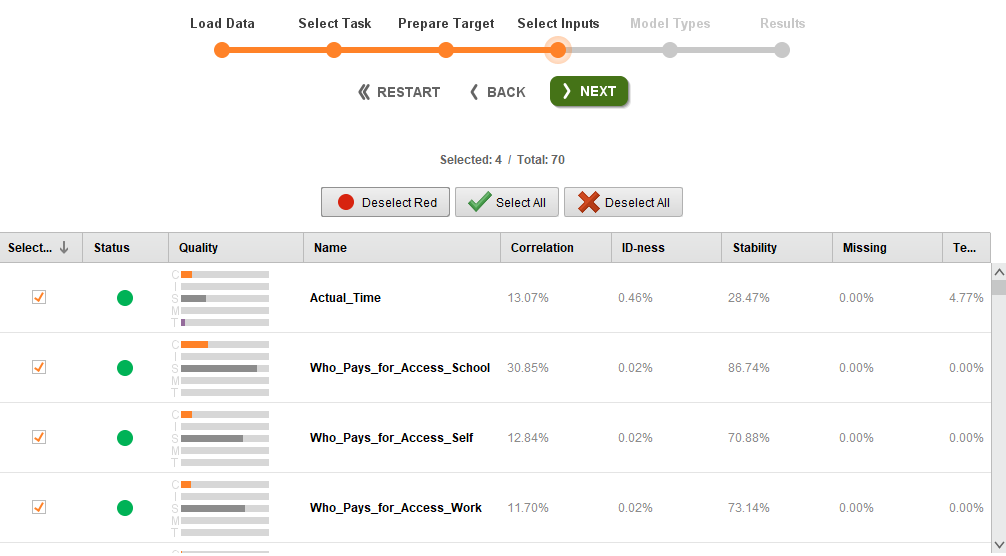

In [33]:
from IPython.display import display, Image
display(Image(filename='rapidminer3.png'))

We need to split the data into training and test examples.For the split, we partition the set so that 70% is used for training and 30% for testing the predictor arising from the training. Also note that we set the `random_state` variable to an integer constant (for the random number generator), so that the same split is derived each time it is run.

In [34]:
from sklearn.model_selection import train_test_split

X = dfSub(['Actual_Time','Who_Pays_for_Access_School', 'Who_Pays_for_Access_Self','Who_Pays_for_Access_Work'])
y = df['Major_Occupation']
# Split dataset into training and test sets
def splitData(X, y):
  testSize=0.3
  randomState=5
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, stratify=y, random_state=randomState)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitData(X, y)
print('Split {0} rows into train={1} and test={2} rows'.format(len(df.index), len(X_train.index), len(X_test.index)))

Split 10108 rows into train=7075 and test=3033 rows


C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='au

Applying StandardScaler

In [35]:
# Apply a scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now we compare `NaiveBayes` `RandomForestClassifier` and `LinearSVC` classifiers. First we prepare for the comparison, which will use k-fold cross-validation rather than simply quoting a single accuracy score.

`LinearSVC` is similar to `SVC` with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples

A random forest fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [38]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# Import the slearn utility to compare algorithms
from sklearn import model_selection

# Prepare an array with the 2 algorithms
models = []
models.append(('NB', GaussianNB()))
models.append(('Linear SVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))

# Prepare the configuration to run the test
seed = 42
results = []
names = []
nSplits = 10

Now we run the comparison

In [39]:
import numpy as np

# Fit the classifiers and output the crossVal results
for name, model in models:
    # We use k-fold cross validation, where 10% of the training data is held back each time 
    kfold = model_selection.KFold(n_splits=nSplits, random_state=seed)
    crossValResults = model_selection.cross_val_score(
        model, X_train_scaled, np.ravel(y_train), cv=kfold, scoring='accuracy')
    results.append(crossValResults)
    names.append(name)
    # Now print the results
    print("%s: %f (%f)" % (name, crossValResults.mean(), crossValResults.std()))

NB: 0.744594 (0.017141)


C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the num

SVC: 0.809332 (0.017761)
RFC: 0.803818 (0.015171)


The cross validation results is the best outcome after checking the same in Rapidminer

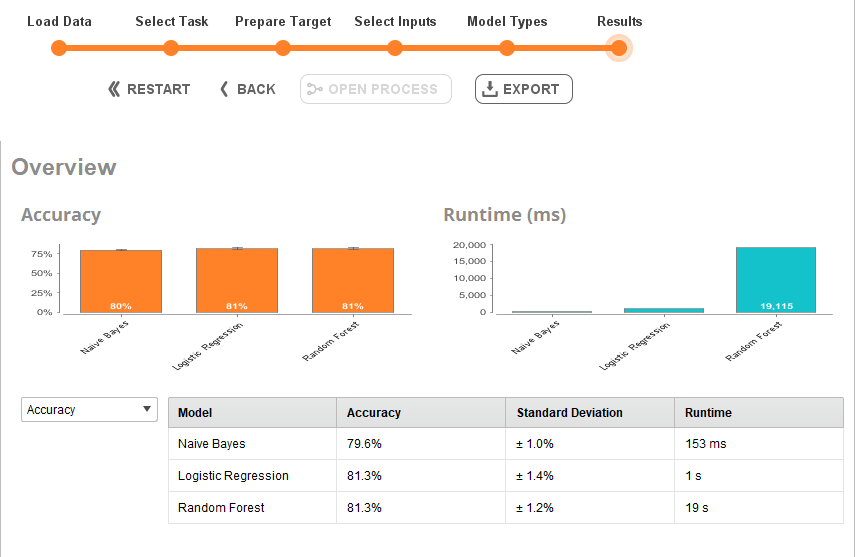

In [42]:
from IPython.display import display, Image
display(Image(filename='rapidminer4.png'))

### Boxplot algorithm comparison

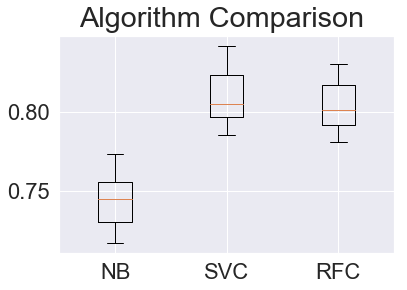

In [43]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### showDiagnostics function for displaying Accuracy, Confusion Matrix and Classification report

In [44]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def showDiagnostics(y, y_pred):
  # Model Accuracy, how often is the classifier correct?
  print("Accuracy:",accuracy_score(y, y_pred))
  print("Confusion Matrix:")
  print(confusion_matrix(y, y_pred))
  print("Classification Report:")
  print(classification_report(y, y_pred, digits=3))

### 1.Naive Bayes Classifier

In [45]:
# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.7543686119353775
Confusion Matrix:
[[388  93  39 129   0]
 [  5 493  12 192   0]
 [  0   0 468 157   0]
 [  0   0  16 686   0]
 [  0   0  33  69 253]]
Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.598     0.745       649
           1      0.841     0.702     0.766       702
           2      0.824     0.749     0.785       625
           3      0.556     0.977     0.709       702
           4      1.000     0.713     0.832       355

   micro avg      0.754     0.754     0.754      3033
   macro avg      0.842     0.748     0.767      3033
weighted avg      0.822     0.754     0.760      3033



### 2.Linear Support Vector Classifier

In [46]:
# Create a Linear Support Vector Classifier
clf=LinearSVC()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.8186613913616881
Confusion Matrix:
[[449 159  41   0   0]
 [ 45 643  14   0   0]
 [  0 151 474   0   0]
 [  0  19  19 664   0]
 [  0  67  35   0 253]]
Classification Report:
              precision    recall  f1-score   support

           0      0.909     0.692     0.786       649
           1      0.619     0.916     0.739       702
           2      0.813     0.758     0.785       625
           3      1.000     0.946     0.972       702
           4      1.000     0.713     0.832       355

   micro avg      0.819     0.819     0.819      3033
   macro avg      0.868     0.805     0.823      3033
weighted avg      0.854     0.819     0.823      3033



C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### 3. Random Forest Classifier

In [47]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForest Classifier, with 100 estimators (decision trees applied to bootstrap samples of the training set)
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training X,Y
clf.fit(X_train,y_train)

# Now use the trained classifier to predict Y (labels) for the test features
y_pred=clf.predict(X_test)

showDiagnostics(y_test, y_pred)

Accuracy: 0.8186613913616881
Confusion Matrix:
[[450 156  43   0   0]
 [ 46 640  16   0   0]
 [  1 147 477   0   0]
 [  0  16  22 664   0]
 [  0  65  38   0 252]]
Classification Report:
              precision    recall  f1-score   support

           0      0.905     0.693     0.785       649
           1      0.625     0.912     0.742       702
           2      0.800     0.763     0.781       625
           3      1.000     0.946     0.972       702
           4      1.000     0.710     0.830       355

   micro avg      0.819     0.819     0.819      3033
   macro avg      0.866     0.805     0.822      3033
weighted avg      0.852     0.819     0.823      3033



By observing the performance metrics of all the classifiers, we can say that it gives good accuracy for `Major Occupation`

### Plotting the selected features by importance

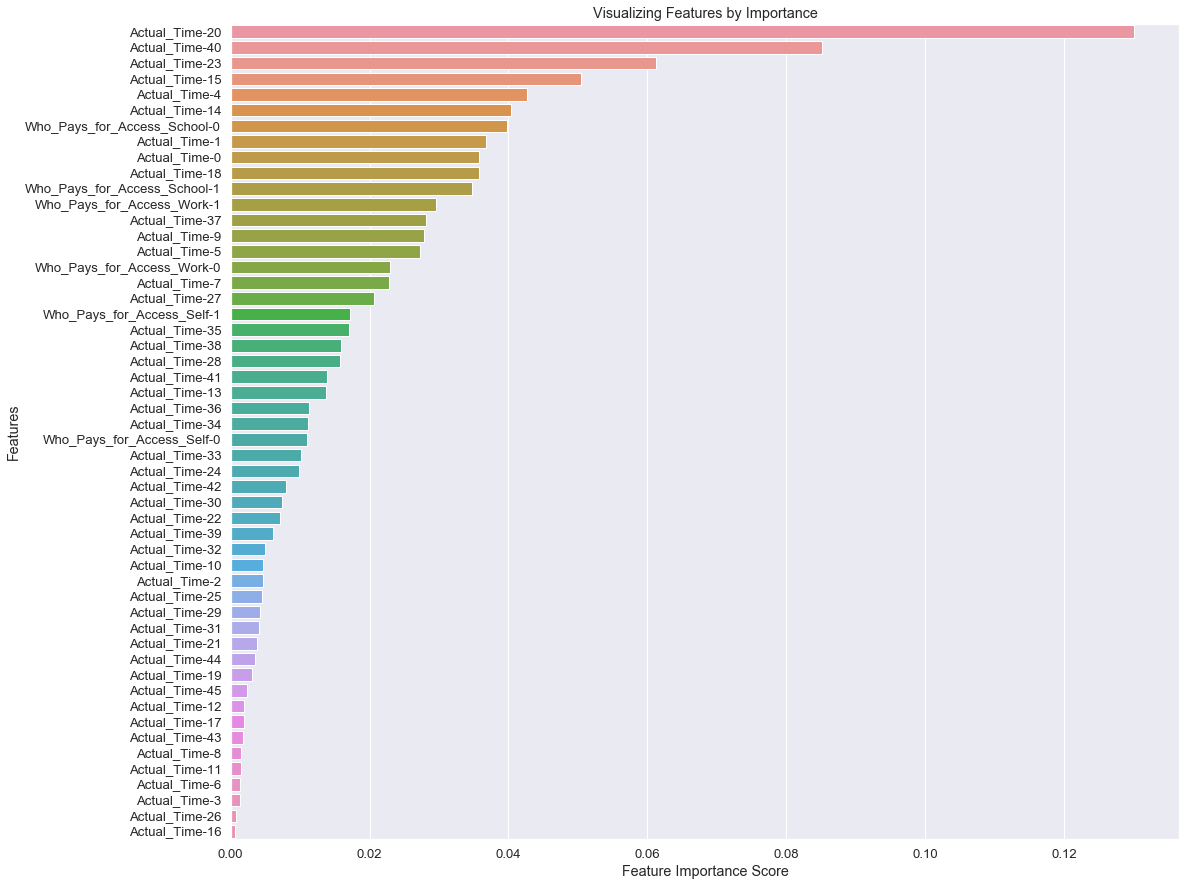

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Bigger than normal fonts
sns.set(font_scale=1.2)
def plotFeaturesByImportance(clf, predNames):
  feature_imp = pd.Series(clf.feature_importances_, index=predNames).sort_values(ascending=False)
  plt.figure(figsize=(17,15))
  # Creating a bar plot
  ax = sns.barplot(x=feature_imp, y=feature_imp.index,label='small')
  # Add labels to your graph
  plt.xlabel('Feature Importance Score')
  plt.ylabel('Features')
  plt.title("Visualizing Features by Importance")
  plt.show()

plotFeaturesByImportance(clf, X.columns.values)

Now, we observe the differences in the classification outcome by dimentionality reduction

First we apply a scaler

In [60]:
# Apply a scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Dimentionality reduction

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(X_scaled)
print("After dimentionality reduction")
print(data.shape)
X_train, X_test, y_train, y_test = splitData(data, y)
# print('Split {0} rows into train={1} and test={2} rows'.format(len(df.index), len(X_train.index), len(X_test.index)))

After dimentionality reduction
(10108, 2)


Now we fit the classifiers and output the cross validation results
Please note that this takes some time to process and throws warnings(which i tried to solve but i couldn't)

In [62]:
import numpy as np

for name, model in models:
    # We use k-fold cross validation, where 10% of the training data is held back each time 
    kfold = model_selection.KFold(n_splits=nSplits, random_state=seed)
    crossValResults = model_selection.cross_val_score(
        model, X_train_scaled, np.ravel(y_train), cv=kfold, scoring='accuracy')
    results.append(crossValResults)
    names.append(name)
    # Now print the results
    print("%s: %f (%f)" % (name, crossValResults.mean(), crossValResults.std()))

NB: 0.744594 (0.017141)


C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the num

SVC: 0.809191 (0.017619)
RFC: 0.804383 (0.014852)


### 1.Naive Bayes Classifier

In [88]:
# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.043521266073194856
Confusion Matrix:
[[  0   0   1   7   0   1  26 217 169]
 [  0   4   8  10   0  19  51 722 174]
 [  0   2   2   0   0   7  15 320  28]
 [  0   1   0  20   0   1   3  18  38]
 [  0   2   2  22   0  12  57 486 264]
 [  0   0   0   3   0   1  10  97  27]
 [  0   0   0   1   0   0   7  35   6]
 [  0   0   0   0   0   2   0  57   1]
 [  0   0   0   0   0   0   3  33  41]]
Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       421
           1      0.444     0.004     0.008       988
           2      0.154     0.005     0.010       374
           3      0.317     0.247     0.278        81
           4      0.000     0.000     0.000       845
           5      0.023     0.007     0.011       138
           6      0.041     0.143     0.063        49
           7      0.029     0.950     0.056        60
           8      0.055     0.532     0.099        77

   micro avg      0.044     0.044 

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2.Linear Support Vector Classifier

In [ ]:
# Create a Linear Support Vector Classifier
clf=LinearSVC()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

### 3. Random Forest Classifier

In [ ]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForest Classifier, with 100 estimators (decision trees applied to bootstrap samples of the training set)
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training X,Y
clf.fit(X_train,y_train)

# Now use the trained classifier to predict Y (labels) for the test features
y_pred=clf.predict(X_test)

showDiagnostics(y_test, y_pred)

Even after dimentionality reduction, no significant changes are observed.

### Selecting feature subsets
I have selected 4 attributes`Actual_Time`,`Who_Pays_for_Access_School`, `Who_Pays_for_Access_Self` and `Who_Pays_for_Access_Work` for predicting `Education_Attainment` based on trying out different features for the best outcome.

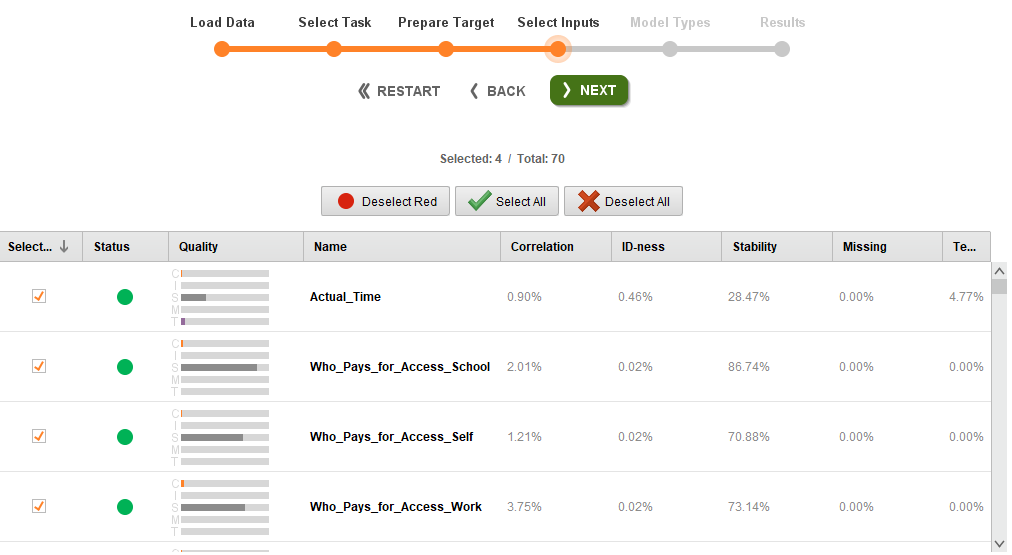

In [63]:
from IPython.display import display, Image
display(Image(filename='rapidminer5.png'))

In [67]:
X = dfSub(['Actual_Time','Who_Pays_for_Access_School', 'Who_Pays_for_Access_Self','Who_Pays_for_Access_Work'])
y = df['Education_Attainment']

X_train, X_test, y_train, y_test = splitData(X, y)
print('Split {0} rows into train={1} and test={2} rows'.format(len(df.index), len(X_train.index), len(X_test.index)))

Split 10108 rows into train=7075 and test=3033 rows


C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='au

Apply a scaler

In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# Prepare an array with the 3 algorithms
models = []
models.append(('NB', GaussianNB()))
models.append(('Linear SVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier(n_estimators=10)))

# Prepare the configuration to run the test
seed = 42
results = []
names = []
nSplits = 10

Now we fit the classifiers and output the cross validation results
Please note that this takes some time to process and throws warnings(which i tried to solve but i couldn't)

In [70]:
import numpy as np

# Fit the classifiers and output the crossVal results
for name, model in models:
    # We use k-fold cross validation, where 10% of the training data is held back each time 
    kfold = model_selection.KFold(n_splits=nSplits, random_state=seed)
    crossValResults = model_selection.cross_val_score(
        model, X_train_scaled, np.ravel(y_train), cv=kfold, scoring='accuracy')
    results.append(crossValResults)
    names.append(name)
    # Now print the results
    print("%s: %f (%f)" % (name, crossValResults.mean(), crossValResults.std()))

NB: 0.049329 (0.006432)


C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the num

SVC: 0.427144 (0.016341)
RFC: 0.420646 (0.019872)


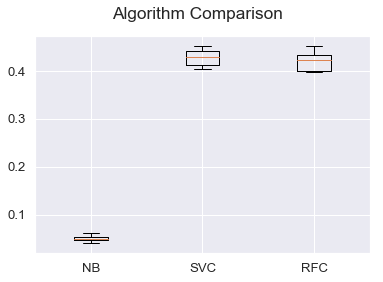

In [71]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We can see that the Naive Bayes performs poorly compared to Linear SVC and RFC.

### 1.Naive Bayes Classifier

In [75]:
# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.043521266073194856
Confusion Matrix:
[[  0   0   1   7   0   1  26 217 169]
 [  0   4   8  10   0  19  51 722 174]
 [  0   2   2   0   0   7  15 320  28]
 [  0   1   0  20   0   1   3  18  38]
 [  0   2   2  22   0  12  57 486 264]
 [  0   0   0   3   0   1  10  97  27]
 [  0   0   0   1   0   0   7  35   6]
 [  0   0   0   0   0   2   0  57   1]
 [  0   0   0   0   0   0   3  33  41]]
Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       421
           1      0.444     0.004     0.008       988
           2      0.154     0.005     0.010       374
           3      0.317     0.247     0.278        81
           4      0.000     0.000     0.000       845
           5      0.023     0.007     0.011       138
           6      0.041     0.143     0.063        49
           7      0.029     0.950     0.056        60
           8      0.055     0.532     0.099        77

   micro avg      0.044     0.044 

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2.Linear Support Vector Classifier

In [76]:
# Create a Linear Support Vector Classifier
clf=LinearSVC()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.4352126607319486
Confusion Matrix:
[[ 57 125   0   4 207   0   0   3  25]
 [ 18 770   2   2 192   0   0   1   3]
 [  1 292   1   0  35   0   0  45   0]
 [  4  21   0  33  18   0   0   0   5]
 [ 44 396   0   5 393   0   0   1   6]
 [  4 105   0   0  29   0   0   0   0]
 [  4  28   0   0   6   0   0  11   0]
 [  0  13   0   0   2   0   0  45   0]
 [  8  20   0   0  28   0   0   0  21]]
Classification Report:
              precision    recall  f1-score   support

           0      0.407     0.135     0.203       421
           1      0.435     0.779     0.558       988
           2      0.333     0.003     0.005       374
           3      0.750     0.407     0.528        81
           4      0.432     0.465     0.448       845
           5      0.000     0.000     0.000       138
           6      0.000     0.000     0.000        49
           7      0.425     0.750     0.542        60
           8      0.350     0.273     0.307        77

   micro avg      0.435     0.435   

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 3. Random Forest Classifier

In [77]:
# Create a RandomForest Classifier
clf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

showDiagnostics(y_test, y_pred)

Accuracy: 0.42960764919221894
Confusion Matrix:
[[ 79 144   4   3 180   0   0   0  11]
 [ 28 769   3   1 183   2   0   1   1]
 [  2 283  16   0  43   0   0  30   0]
 [  3  21   0  33  19   0   0   0   5]
 [ 56 415   3   2 364   0   0   0   5]
 [  5 105   1   0  27   0   0   0   0]
 [  2  27   1   0   9   0   0  10   0]
 [  0  13  13   0   3   0   0  31   0]
 [ 19  18   0   0  29   0   0   0  11]]
Classification Report:
              precision    recall  f1-score   support

           0      0.407     0.188     0.257       421
           1      0.428     0.778     0.553       988
           2      0.390     0.043     0.077       374
           3      0.846     0.407     0.550        81
           4      0.425     0.431     0.428       845
           5      0.000     0.000     0.000       138
           6      0.000     0.000     0.000        49
           7      0.431     0.517     0.470        60
           8      0.333     0.143     0.200        77

   micro avg      0.430     0.430  

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In all the classfiers used here for predicting `Education_Attainment`, some features are observed to be insignificant(as seen from the Classification report) and can be removed.

Plotting the selected features by importance

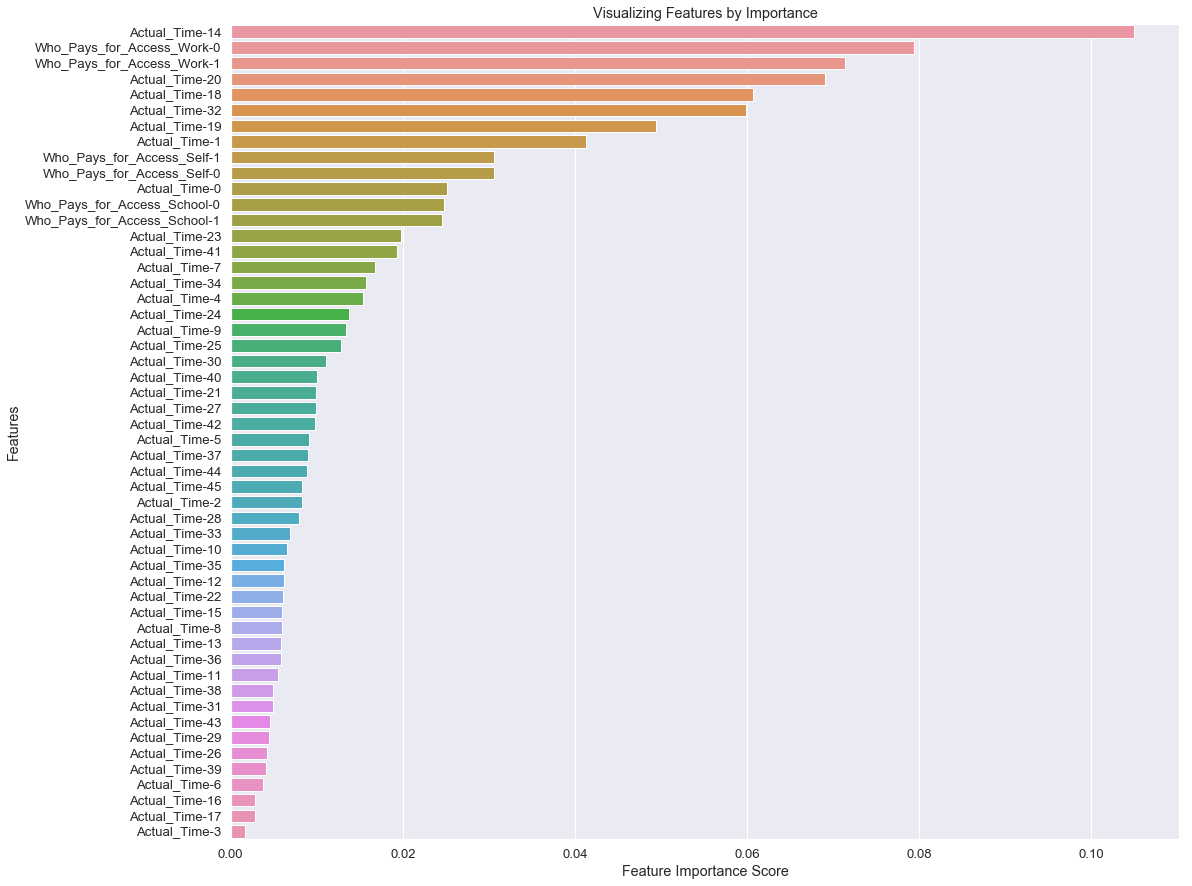

In [78]:
plotFeaturesByImportance(clf, X.columns.values)

Now, we observe the differences in the classification outcome by dimentionality reduction

Apply a scaler

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Dimentionality reduction

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(X)
print("After dimentionality reduction")
print(data.shape)
X_train, X_test, y_train, y_test = splitData(data, y)
# print('Split {0} rows into train={1} and test={2} rows'.format(len(df.index), len(X_train.index), len(X_test.index)))

After dimentionality reduction
(10108, 2)


Now we fit the classifiers and output the cross validation results
Please note that this takes some time to process and throws warnings(which i tried to solve but i couldn't)

In [82]:
import numpy as np

# Fit the classifiers and output the crossVal results
for name, model in models:
    # We use k-fold cross validation, where 10% of the training data is held back each time 
    kfold = model_selection.KFold(n_splits=nSplits, random_state=seed)
    crossValResults = model_selection.cross_val_score(
        model, X_train_scaled, np.ravel(y_train), cv=kfold, scoring='accuracy')
    results.append(crossValResults)
    names.append(name)
    # Now print the results
    print("%s: %f (%f)" % (name, crossValResults.mean(), crossValResults.std()))

NB: 0.049329 (0.006432)


C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the num

SVC: 0.425165 (0.017891)
RFC: 0.424180 (0.022194)


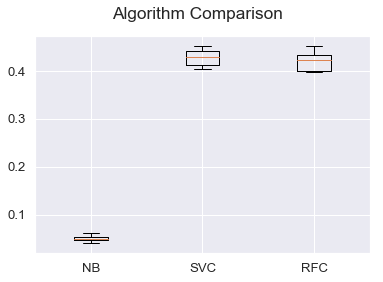

In [71]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 1.Naive Bayes Classifier

In [85]:
# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.043521266073194856
Confusion Matrix:
[[  0   0   1   7   0   1  26 217 169]
 [  0   4   8  10   0  19  51 722 174]
 [  0   2   2   0   0   7  15 320  28]
 [  0   1   0  20   0   1   3  18  38]
 [  0   2   2  22   0  12  57 486 264]
 [  0   0   0   3   0   1  10  97  27]
 [  0   0   0   1   0   0   7  35   6]
 [  0   0   0   0   0   2   0  57   1]
 [  0   0   0   0   0   0   3  33  41]]
Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       421
           1      0.444     0.004     0.008       988
           2      0.154     0.005     0.010       374
           3      0.317     0.247     0.278        81
           4      0.000     0.000     0.000       845
           5      0.023     0.007     0.011       138
           6      0.041     0.143     0.063        49
           7      0.029     0.950     0.056        60
           8      0.055     0.532     0.099        77

   micro avg      0.044     0.044 

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 2.Linear Support Vector Classifier

In [86]:
# Create a Linear Support Vector Classifier
clf=LinearSVC()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_scaled,np.ravel(y_train))

# prediction on test set
y_pred=clf.predict(X_test_scaled)

showDiagnostics(y_test, y_pred)

Accuracy: 0.4332344213649852
Confusion Matrix:
[[ 51 125   0   3 214   0   0   3  25]
 [ 18 762  11   1 192   0   0   1   3]
 [  1 288   5   0  35   0   0  45   0]
 [  3  21   0  33  19   0   0   0   5]
 [ 42 393   4   2 397   0   0   1   6]
 [  3 105   0   0  30   0   0   0   0]
 [  3  28   0   0   7   0   0  11   0]
 [  0  12   1   0   2   0   0  45   0]
 [  6  20   0   0  30   0   0   0  21]]
Classification Report:
              precision    recall  f1-score   support

           0      0.402     0.121     0.186       421
           1      0.434     0.771     0.556       988
           2      0.238     0.013     0.025       374
           3      0.846     0.407     0.550        81
           4      0.429     0.470     0.448       845
           5      0.000     0.000     0.000       138
           6      0.000     0.000     0.000        49
           7      0.425     0.750     0.542        60
           8      0.350     0.273     0.307        77

   micro avg      0.433     0.433   

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Linear SFC takes more time to compute compared to Naive Bayes

### 3. Random Forest Classifier

In [87]:
# Create a RandomForest Classifier
clf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

showDiagnostics(y_test, y_pred)

Accuracy: 0.42861852950873724
Confusion Matrix:
[[ 79 134   4   3 188   0   0   0  13]
 [ 32 750   8   2 193   1   0   1   1]
 [  3 276  19   0  46   0   0  30   0]
 [  3  21   0  33  19   0   0   0   5]
 [ 55 401   2   3 376   0   0   0   8]
 [  5 104   1   0  28   0   0   0   0]
 [  2  26   1   0  10   0   0  10   0]
 [  0  11  14   0   4   0   0  31   0]
 [ 17  18   0   0  30   0   0   0  12]]
Classification Report:
              precision    recall  f1-score   support

           0      0.403     0.188     0.256       421
           1      0.431     0.759     0.550       988
           2      0.388     0.051     0.090       374
           3      0.805     0.407     0.541        81
           4      0.421     0.445     0.432       845
           5      0.000     0.000     0.000       138
           6      0.000     0.000     0.000        49
           7      0.431     0.517     0.470        60
           8      0.308     0.156     0.207        77

   micro avg      0.429     0.429  

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In all the classfiers used here for predicting `Education_Attainment`, some features are observed to be insignificant(as seen from the Classification report) and can be removed. The effects of dimentionality reduction are not significant in this case. Naive Bayes performs very poorly.